# Step size experiment

This notebook contains experiments with the step size in Reinforcement Learning methods.

The convergence of a stochastic process is given with probability 1 iff $\sum_{n=1}^{\infty} \alpha_n(a) = \infty$ and $\sum_{n=1}^{\infty} \alpha_n^2(a) < \infty$. This is theoretically satisfied if $\alpha\in(0,1)$. This notebook will therefore compare values of $\alpha$.

An implementation of the Sarsa algorithm to solve the windy gridworld problem (with King's moves) is chosen for this experiment. This is due to the fact that both the algorithm and the environment is fast to execute. It is clear that this is a tabular method instead of an approximate method, but as has been established in the theoretical exercises, the tabular case is simply a special case of the general function approximation case. Here, the action value table serves as the action value function $\hat{q}(s,\boldsymbol{\theta})$, which is the function to be optimized. The findings here are similar in function approximation approaches.

In [1]:
using Plots
using Statistics
using Base.Iterators

In [2]:
gamma = 1.
epsilon = .1
alpha = .5
episodes = 170

170

In [3]:
mutable struct Gridworld
    wind::Array{Int32}
    rows::Int32
    agent::CartesianIndex{2}
    goal::CartesianIndex{2}
end

reset_state(g::Gridworld) = g.agent = CartesianIndex(4, 1)

"""
Performs an action on the gridworld and returns the recieved reward and a termination flag.

# Arguments
- `action`:
    - 1: left
    - 2: right
    - 3: up
    - 4: down
    - 5: left-up
    - 6: right-up
    - 7: left-down
    - 8: right-down
    - 9: none
"""
function act(g::Gridworld, action::Int64; stochastic=false)
    agent_row = g.agent[1]
    agent_col = g.agent[2]
    
    if action == 1
        agent_col -= 1
    elseif action == 2
        agent_col += 1
    elseif action == 3
        agent_row -= 1
    elseif action == 4
        agent_row += 1
    elseif action == 5
        agent_row -= 1
        agent_col -= 1
    elseif action == 6
        agent_row -= 1
        agent_col += 1
    elseif action == 7
        agent_row += 1
        agent_col -= 1
    elseif action == 8
        agent_row += 1
        agent_col += 1
    end
    
    agent_row -= g.wind[g.agent[2]]
    if stochastic
        agent_row += rand([-1,0,1])
    end
    agent_row = clamp(agent_row, 1, g.rows)
    agent_col = clamp(agent_col, 1, length(g.wind))
    
    g.agent = CartesianIndex(agent_row, agent_col)
    reward = -1
    episode_end = false
    if g.agent == g.goal
        reward = 0
        episode_end = true
    end
    return reward, episode_end
end

act

In [4]:
"""
Applies the Sarsa algorithm (an on-policy TD control method) to the Windy Gridworld problem. Returns the value table and the steps needed per episode.
"""
function sarsa(g::Gridworld, actions, episodes::Int64; gamma=gamma, alpha=alpha, decay=1, epsilon=epsilon, stochastic=false)
    num_actions = length(actions)
    values = zeros(g.rows, length(g.wind), num_actions)
    
    steps = []
    for episode in 1:episodes
        reset_state(g)
        step = 0
        episode_end = false
        state = g.agent
        action = rand() < epsilon ? rand(actions) : argmax(values[state, :])
        while !episode_end
            step += 1
            reward, episode_end = act(g, action; stochastic=stochastic)
            state_new = g.agent
            action_new = rand() < epsilon ? rand(actions) : argmax(values[state_new, :])
            values[state, action] += alpha * (reward + gamma * values[state_new, action_new] - values[state, action])
            state = state_new
            action = action_new
        end
        push!(steps, step)
        alpha *= decay
    end
    
    values, steps
end

sarsa

In [5]:
actions = 1:9
wind = [0,0,0,1,1,1,2,2,1,0]
rows = 7
agent = CartesianIndex(4, 1)
goal = CartesianIndex(4, 8)
gridworld = Gridworld(wind, rows, agent, goal)

Gridworld(Int32[0, 0, 0, 1, 1, 1, 2, 2, 1, 0], 7, CartesianIndex(4, 1), CartesianIndex(4, 8))

In [6]:
alphas = [0.1 0.5 0.8 1 1.2 1.5]

"""
Runs the Sarsa algorithm multiple times and returns the resulting steps needed to reach the goal.
"""
function run_experiment(alpha; decay=1, stochastic=false)
    runs = 50
    steps_per_episode = zeros(runs, episodes)

    for run in 1:runs
        _, steps = sarsa(gridworld, 1:9, episodes; stochastic=stochastic, alpha=alpha, decay=decay)
        steps_per_episode[run, :] = steps
    end
    steps_per_episode
end

steps_per_alpha = []
for alpha in alphas
    steps_per_episode = run_experiment(alpha)
    avg_steps = transpose(mean(steps_per_episode, dims=1))
    push!(steps_per_alpha, avg_steps)
end

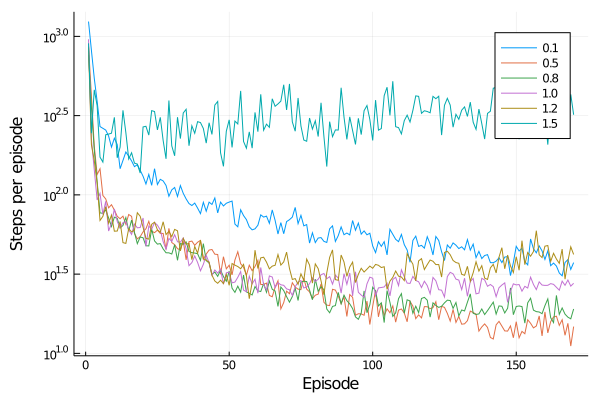

In [7]:
plot(
    steps_per_alpha,
    label=alphas,
    yaxis=:log,
    xlab="Episode",
    ylab="Steps per episode"
)

The above plot shows the result of the step size experiment with constant step sizes. In the case of constant step sizes, the step size is the learning rate, i.e. $\alpha_n=\alpha$ $\forall n$. The plot very nicely shows how the step size affects the learning process. We see that $\alpha=0.1$ leads to much slower convergence of the value function than the other approaches. Setting $\alpha$ to 0.5 or 0.8 leads to the quickest convergence. This shows that there is no single optimal learning rate to be found. Instead, each task has a specific range $\alpha\in[0.5,0.8]$ in which each value leads to optimal convergence.

The initial values all satisfy the convergence theory properties specified at the top of the notebook. The first possible value to violate the second property is $\alpha=1$. In the above graph, we see that this learning rate still leads to a passable result, but it is clearly worse than the optimal result. However, it still seems to  converge. The first learning rate which diverges is $\alpha=1.2$. Here we see that the steps per episode actually increase again after ~ episode 50. But even more noticable is the case of $\alpha=1.5$, which finds a premature optimum after only < 10 episodes and then quickly diverges. This shows that a learning rate $\alpha>1$ is too high for this task, because it overzealously adapts the value function to the observed returns.

In [12]:
steps_per_alpha = []
for alpha in alphas
    steps_per_episode = run_experiment(alpha; decay=0.8)
    avg_steps = transpose(mean(steps_per_episode, dims=1))
    push!(steps_per_alpha, avg_steps)
end

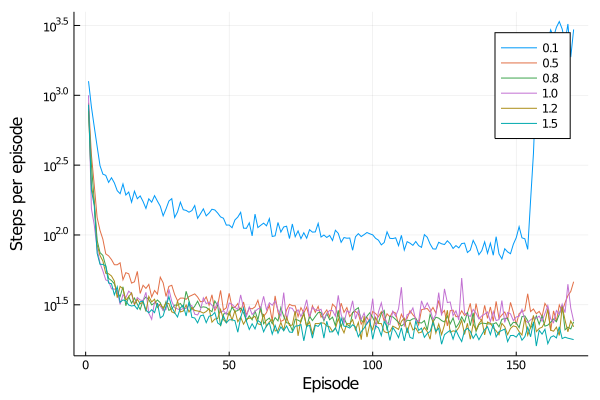

In [13]:
plot(
    steps_per_alpha,
    label=alphas,
    yaxis=:log,
    xlab="Episode",
    ylab="Steps per episode"
)

The above plot is concerned with changing step sizes. In this case, there is a step size decay, i.e. the learning rate and the step size do not coincide and $\alpha_{n+1} < \alpha_{n}$ $\forall n$. This fact violates the first property specified at the top of the notebook, since the sum of all step sizes is bounded by a finite number (since $\alpha_{n}=0$ for a specific large value of $n$ and afterwards). The step size decay is set to a value $\in (0, 1)$. The decay is implemented to happen after each episode. Only decaying within an episode would lead to sharp increases of $\alpha_n$ after $n=T$, therefore this is not implemented. 

Unfortunately, it is not possible to show plots for too agressive decay values, since the episodes never come to a close. Also, decay value $>1$ increase the step size too quickly and therefore also display no learning. By running the algorithm with multiple decay values, it could be confirmed that the decay must be $\in [0.8, 1]$ in order for at least some learning to occur. The results are generally a bit more unstable.

The smallest decay value of 0.8 already displays an interesting result. On the one hand, the most obvious result is that $\alpha=0.1$ stagnates and diverges after ~ 150 episodes. Clearly, at some early point $\alpha_n$ is too small to improve the value approximation. But the other interesting result is that the findings of the plot before are inverted. Here, $\alpha=1.5$ leads to a (admittedly only slightly) better result than $\alpha\in[0.5,0.8]$. This is obviously because the decay forces the step size down to a reasonable level for this task, even if it starts from a very high initial value. It also goes to show that decay enables the high learning rate values to satisfy condition 2.

The below plot shows the same for a decay value of 0.9. Here, we can see a higher variance for $\alpha=1.5$. The high variance compared to other learning rates shows that it is a bit more unstable. It can also be seen that a decay value of 0.9 is still aggressive enough for $\alpha=1.2$ to converge in all cases. The higher decay value also allows $\alpha=0.1$ to recover its earlier result.

In [16]:
steps_per_alpha = []
for alpha in alphas
    steps_per_episode = run_experiment(alpha; decay=0.9)
    avg_steps = transpose(mean(steps_per_episode, dims=1))
    push!(steps_per_alpha, avg_steps)
end

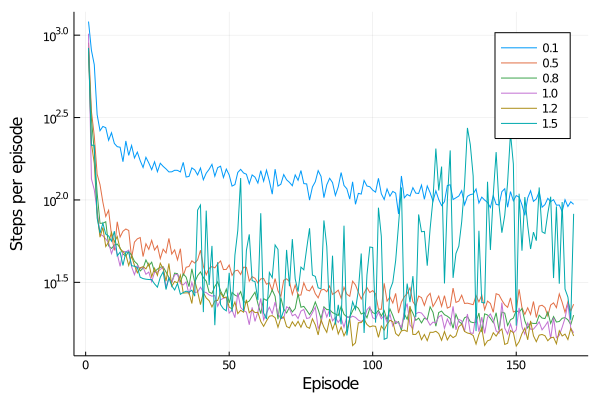

In [17]:
plot(
    steps_per_alpha,
    label=alphas,
    yaxis=:log,
    xlab="Episode",
    ylab="Steps per episode"
)

In general, constant step sizes should be used in continuing tasks, since with step size decay at some point the agent would simply not learn anymore. Also, constant step sizes are useful if the environment changes over time. In other cases (episodic and unchanging environments), decaying the step size is a possible trick to speed up learning, but not always required. In this case, step size decay did in fact lead to quicker convergence, since the agent reached the performance of 170 steps with constant step size already after < 100 episodes with decaying step size. Additionally, step size decay allows to use high initial step sizes, which could be an attractive property depending on the task. In general, adding step size decay is favourable to the learning process, but one has to be careful not to endanger the stability of the learning process.